# GRU-ODE

This example trains a [GRU-ODE](https://arxiv.org/abs/1905.12374) (a continuous time GRU-cells network) to predict a global parameter in a synthetic spirals dataset.

In [9]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx # https://github.com/patrick-kidger/equinox
import diffrax
import optax # https://github.com/deepmind/optax
import matplotlib.pyplot as plt

We use [Equinox](https://github.com/patrick-kidger/equinox) to build neural networks. We use [Optax](https://github.com/deepmind/optax) for optimisers (Adam etc.)

The dataset contains 10_000 spirals, which were generated using a parameter alpha and some noise. We are trying to predict the alpha for each spiral.

![Spirals Dataset](../imgs/trajectories_and_alpha_distribution.png)

In [10]:
spirals = jnp.load("spirals.npz")

data_train = spirals["xy_train"]
data_test = spirals["xy_test"]
alpha_train = spirals["alpha_train"]

# z-score transform
data_mean = jnp.mean(data_train, axis=(0, 1), keepdims=True)
data_std = jnp.std(data_train, axis=(0, 1), keepdims=True)
alpha_mean = jnp.mean(alpha_train, axis=0, keepdims=True)
alpha_std = jnp.std(alpha_train, axis=0, keepdims=True)

ts_train = jnp.repeat(jnp.linspace(0, 1, data_train.shape[1])[None, :], data_train.shape[0], axis=0)

In [11]:
class ContinuousGRUField(eqx.Module):
    lin_z: eqx.nn.Linear
    lin_r: eqx.nn.Linear
    lin_g: eqx.nn.Linear

    def __init__(self, hidden_size, key):
        k1, k2, k3 = jrandom.split(key, 3)
        self.lin_z = eqx.nn.Linear(hidden_size, hidden_size, key=k1)
        self.lin_r = eqx.nn.Linear(hidden_size, hidden_size, key=k2)
        self.lin_g = eqx.nn.Linear(hidden_size, hidden_size, key=k3)

    def __call__(self, t, h, args):
        z = jax.nn.sigmoid(self.lin_z(h))
        r = jax.nn.sigmoid(self.lin_r(h))
        g = jax.nn.tanh(self.lin_g(r * h))
        return (1 - z) * (g - h)

In [12]:
class GRU_ODE(eqx.Module):
    vector_field: ContinuousGRUField
    observation_update: eqx.nn.GRUCell
    linear_out: eqx.nn.Linear
    hidden_size: int

    def __init__(self, in_size, hidden_size, out_size, key):
        k1, k2, k3 = jrandom.split(key, 3)
        self.hidden_size = hidden_size
        
        self.vector_field = ContinuousGRUField(hidden_size, key=k1)
        self.observation_update = eqx.nn.GRUCell(in_size, hidden_size, key=k2)
        self.linear_out = eqx.nn.Linear(hidden_size, out_size, key=k3)

    def __call__(self, ts, obs):
        h0 = jnp.zeros(self.hidden_size)
        
        init_carry = (h0, ts[0])
        xs = (ts[1:], obs[1:])

        def scan_fn(carry, x):
            h_prev, t_prev = carry
            t_curr, obs_curr = x
            
            sol = diffrax.diffeqsolve(
                diffrax.ODETerm(self.vector_field),
                diffrax.Tsit5(),
                t0=t_prev,
                t1=t_curr,
                dt0=t_curr - t_prev,
                y0=h_prev
            )
            h_ode_evolved = sol.ys[0]

            h_next = self.observation_update(obs_curr, h_ode_evolved)

            return (h_next, t_curr), h_next

        (h_final, _), _ = jax.lax.scan(scan_fn, init_carry, xs)

        return self.linear_out(h_final)

In [13]:
BATCH_SIZE = 64

key = jrandom.PRNGKey(567)
model = GRU_ODE(in_size=2, hidden_size=16, out_size=1, key=key)

optimizer = optax.adamw(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

@eqx.filter_value_and_grad
def loss_fn(model, batch_ts, batch_obs, batch_y):
    pred_y = jax.vmap(model)(batch_ts, batch_obs)
    return jnp.mean((pred_y - batch_y) ** 2)

@eqx.filter_jit
def make_step(model, opt_state, batch_ts, batch_obs, batch_y):
    loss, grads = loss_fn(model, batch_ts, batch_obs, batch_y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

loss_history = []

In [6]:
for epoch in range(10):
    key, subkey = jrandom.split(key)
    perm = jrandom.permutation(subkey, data_train.shape[0])
    epoch_loss = 0.0
    for start in range(0, data_train.shape[0], BATCH_SIZE):
        batch_idx = perm[start : start + BATCH_SIZE]
        batch_ts = ts_train[batch_idx]
        batch_obs = data_train[batch_idx, :, :]
        batch_y = alpha_train[batch_idx]
        
        batch_obs = (batch_obs - data_mean) / data_std
        batch_y = (batch_y - alpha_mean) / alpha_std

        model, opt_state, loss = make_step(model, opt_state, batch_ts, batch_obs, batch_y)
        loss_history.append(loss)
        epoch_loss += loss.item() * batch_idx.shape[0]
    epoch_loss /= data_train.shape[0]
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.5017
Epoch 2, Loss: 0.1869
Epoch 3, Loss: 0.1166
Epoch 4, Loss: 0.0840
Epoch 5, Loss: 0.0655
Epoch 6, Loss: 0.0525
Epoch 7, Loss: 0.0429
Epoch 8, Loss: 0.0356
Epoch 9, Loss: 0.0296
Epoch 10, Loss: 0.0252


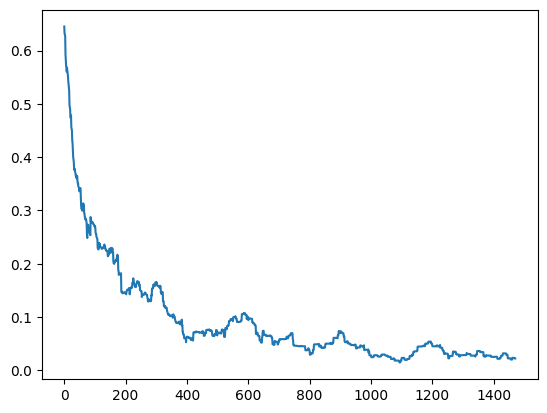

In [7]:
# Plot loss history moving average
window_size = 100
loss_history_ma = jnp.convolve(jnp.array(loss_history), jnp.ones(window_size)/window_size, mode='valid')
plt.plot(loss_history_ma)

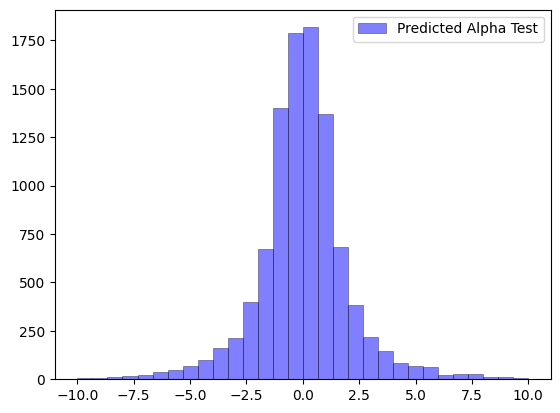

In [8]:
# predict alpha test
data_test_normalized = (data_test - data_mean) / data_std
pred_alpha_test_normalized = jax.vmap(model)(ts_train[:data_test.shape[0]], data_test_normalized)
pred_alpha_test = pred_alpha_test_normalized * alpha_std + alpha_mean

# plot in hist
plt.hist(pred_alpha_test.flatten(), bins=30, alpha=0.5, label='Predicted Alpha Test', color='blue', range=(-10, 10), edgecolor='black', linewidth=0.5)
plt.legend()
plt.show()